In [1]:
import config, pickle
import matplotlib.pyplot as plt
import numpy as np
import models

/Users/hangil/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
Iperiods = pickle.load(open(config.fluid_incentive_periods, 'rb'))
static_Iperiods = pickle.load(open((config.static_incentive_periods).format(0.1), 'rb'))
rates = pickle.load(open(config.flow_rates_final, 'rb'))
base_rates = pickle.load(open(config.base_rates_final, 'rb'))
tripDF = pickle.load(open(config.tripDF_pickle, 'rb'))
rideProb = models.get_ride_prob(rates, base_rates)
AMstations = pickle.load(open(config.curr_Istations, 'rb'))

In [31]:
# Stations

EV = [438, 326, 237, 236, 439, 428, 432,
        301, 393, 433, 445, 394, 317, 403, 150, 302]

FiDi = [279, 306, 376, 195, 264, 360, 304, 260,
            534, 259, 427, 315, 337, 415, 319, 387]

In [59]:
stations = FiDi

startA = []
endA = []
for d in Iperiods:
    for s in stations:
        if s in Iperiods[d]:
            startA.append(Iperiods[d][s][0])
            endA.append(Iperiods[d][s][1])

noise = np.random.random(len(startA)) / 2
noise2 = np.random.random(len(startA)) / 2

startA = np.array(startA) / 60. + noise
endA = np.array(endA) / 60. + noise2


# Create heatmap
heatmap, xedges, yedges = np.histogram2d(startA, endA, bins=(64,64))
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
 
# Plot heatmap
plt.clf()
plt.imshow(heatmap, extent=extent)
plt.title("start and end incentive periods")
plt.xlabel("start incentive period")
plt.ylabel("end incentive period")
plt.savefig('./plots/heatmap_FiDi_start_end_incentive_period.png')
plt.close()

In [60]:
# scatter start and end of incentive periods
plt.scatter(startA,endA,alpha = 0.1)
plt.title("start and end incentive periods")
plt.xlabel("start incentive period")
plt.ylabel("end incentive period")
plt.ylim(5,13)
plt.xlim(5,13)
plt.savefig('./plots/scatter_FiDi_start_end_incentive_period.png')
plt.close()

In [5]:
relevantdata = tripDF[(tripDF['start status'] < 0) & (tripDF['end status'] == 0)]
# scatter end station improvement vs start station improvement
plt.scatter(relevantdata.startDeltaCC,relevantdata.endDeltaCC,alpha = 0.1)
plt.title("dropoff DCC vs pickup DCC only start station incentivized")
plt.xlabel("start station Delta CC")
plt.ylabel("end station Delta CC")
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.savefig('./plots/scatter_start incent end neutral.png')
plt.close()

In [6]:
relevantdata = tripDF[(tripDF['start status'] == 0) & (tripDF['end status'] >0 )]
# scatter end station improvement vs start station improvement
plt.scatter(relevantdata.startDeltaCC,relevantdata.endDeltaCC,alpha = 0.1)
plt.title("dropoff DCC vs pickup DCC only end station incentivized")
plt.xlabel("start station Delta CC")
plt.ylabel("end station Delta CC")
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.savefig('./plots/scatter_start neutral end incent.png')
plt.close()

In [7]:
relevantdata = tripDF[(tripDF['start status'] < 0) & (tripDF['end status'] > 0)]
# scatter end station improvement vs start station improvement
plt.scatter(relevantdata.startDeltaCC,relevantdata.endDeltaCC,alpha = 0.1)
plt.title("dropoff DCC vs pickup DCC both start and end station incentivized")
plt.xlabel("start station Delta CC")
plt.ylabel("end station Delta CC")
plt.ylim(-1.1,1.1)
plt.xlim(-1.1,1.1)
plt.savefig('./plots/scatter_start incent end incent.png')
plt.close()
        

In [37]:
import numpy as np
num_days = len(rates)
num_stations = len(rates[rates.keys()[0]])
num_time = 48

incentA = np.zeros(shape=(num_days, num_stations, num_time))
normA = np.zeros(shape=(num_days, num_stations, num_time))
baseA = np.zeros(shape=(num_stations, num_time))
stations = rates[rates.keys()[0]].keys()
stations.sort()
for i, d in enumerate(rates):
    for j, s in enumerate(stations):
        for k, t in enumerate(range(48)):
            incentA[i][j][k] = rates[d][s][t]['out']['incent'] - rates[d][s][t]['in']['incent'] 
            normA[i][j][k] = rates[d][s][t]['out']['normal'] - rates[d][s][t]['in']['normal']
            baseA[j][k] = base_rates[s][t]['out'] - base_rates[s][t]['in']
            
incentA = incentA.mean(axis = 0)
normA = normA.mean(axis = 0)

In [38]:
%matplotlib inline
dates = rates.keys()

for i, s in enumerate(stations):
    iA = incentA[i] * 30
    nA = normA[i] * 30
    bA = baseA[i] * 30
    
    iA = iA[12:24]
    nA = nA[12:24]
    bA = bA[12:24]
    X = np.arange(12, 24) *30.0 / 60.0
    fig = plt.figure()
    plt.plot(X, iA, 'r-', label = 'incent angels')
    plt.plot(X, nA, 'b-', label= 'normal')
    plt.plot(X, bA, 'g-', label='non-incent angels')
    
    plt.legend(loc= 'upper right')
    fig.savefig('./plots/rates/rates_{0}.png'.format(s), dpi=fig.dpi)
    if s in EV:
        fig.savefig('./plots/rates/EV/rates_{0}.png'.format(s), dpi=fig.dpi)
    if s in FiDi:
        fig.savefig('./plots/rates/FiDi/rates_{0}.png'.format(s), dpi=fig.dpi)
    #plt.show()
    plt.close(fig)

In [55]:
# Plot endtrips for all riders
station_types = [EV, FiDi]
filenames = ['EV', 'FiDi']
for filename, curr_stations in zip(filenames, station_types):
    inrateA = np.zeros(shape=(48,))
    outrateA = np.zeros(shape=(48,))
    for i, d in enumerate(rates):
        for j, s in enumerate(stations):
            if s not in curr_stations:
                continue
            for k, t in enumerate(range(48)):
                inrateA[k] += rates[d][s][t]['in']['incent'] 
                inrateA[k] += rates[d][s][t]['in']['normal']

                outrateA[k] += rates[d][s][t]['out']['incent'] 
                outrateA[k] += rates[d][s][t]['out']['normal']

    inrateA /= float(len(rates)) * 30.0
    outrateA /= float(len(rates)) * 30.0
    diffA = outrateA - inrateA
    X = np.arange(48) *30.0 / 60.0

    fig = plt.figure()
    plt.plot(X, inrateA, 'r-', label = 'inflow')
    plt.plot(X, outrateA, 'b-', label= 'outflow')
    plt.plot(X, diffA, 'g-', label='net flow')
    plt.legend(loc= 'upper right')
    fig.savefig('./plots/{0}_rides_cumu.png'.format(filename), dpi=fig.dpi)
    plt.close(fig)
        
    
    

In [39]:
import numpy as np
num_days = len(rates)
num_stations = len(rates[rates.keys()[0]])
num_time = 48

incentA = np.zeros(shape=(num_days, num_stations, num_time))
normA = np.zeros(shape=(num_days, num_stations, num_time))
baseA = np.zeros(shape=(num_stations, num_time))
stations = rates[rates.keys()[0]].keys()
stations.sort()
for i, d in enumerate(rates):
    for j, s in enumerate(stations):
        for k, t in enumerate(range(48)):
            if s in AMstations:
                if AMstations[s] == -1:
                    incentA[i][j][k] = rates[d][s][t]['out']['incent'] 
                    baseA[j][k] = base_rates[s][t]['out']
                elif AMstations[s] == 1:
                    incentA[i][j][k] = -1. * rates[d][s][t]['in']['incent'] 
                    baseA[j][k] = -1. *base_rates[s][t]['in']
                else:
                    incentA[i][j][k] = rates[d][s][t]['out']['incent']  - rates[d][s][t]['in']['incent']
                    baseA[j][k] = base_rates[s][t]['out'] - base_rates[s][t]['in']
                
                normA[i][j][k] = rates[d][s][t]['out']['normal'] - rates[d][s][t]['in']['normal']
            
incentA = incentA.mean(axis = 0)
normA = normA.mean(axis = 0)

In [40]:
%matplotlib inline
dates = rates.keys()

import pdb
error_c = 0
for i, s in enumerate(stations):
    if s not in AMstations:
        error_c += 1
        continue
    iA = incentA[i] * 30
    nA = normA[i] * 30
    bA = baseA[i] * 30
    
    iA = iA[12:24]
    nA = nA[12:24]
    bA = bA[12:24]
    X = np.arange(12, 24) *30.0 / 60.0
    fig = plt.figure(figsize=(10.0, 10.0))
    plt.plot(X, iA, 'r-', label = 'incent angels')
    plt.plot(X, nA, 'b-', label= 'normal')
    plt.plot(X, bA, 'g-', label='non-incent angels')
    
    y = min(min(np.min(iA), np.min(nA)), np.min(bA))
    inc = 0.4
    y -= inc
    for count,d in enumerate(dates):
        if s not in Iperiods[d]:
            continue
        if count % 2 == 1 or (static_Iperiods[d][s][0] == 360 and static_Iperiods[d][s][1] == 360):
            continue
            
        start = (Iperiods[d][s][0] / 60.)
        end = (Iperiods[d][s][1] / 60.)
        plt.hlines(y=y, xmin = start, xmax= end, colors='r')
        y -= inc
                
        start = (static_Iperiods[d][s][0] / 60.)
        end = (static_Iperiods[d][s][1] / 60.)
        plt.hlines(y=y, xmin = start, xmax= end, colors='b')
        y -= inc
    
    y_max = max(max(np.max(iA), np.max(nA)), np.max(bA))
    plt.ylim((y - inc, y_max +7))
    plt.legend(loc= 'upper right')
    incent = 'end'
    if AMstations[s] == -1:
        incent = 'start'
    fig.savefig('./plots/rates_incent/rates_{0}_{1}.png'.format(s, incent))
    if s in EV:
        fig.savefig('./plots/rates_incent/EV/rates_{0}_{1}.png'.format(s, incent))
    if s in FiDi:
        fig.savefig('./plots/rates_incent/FiDi/rates_{0}_{1}.png'.format(s, incent))
    #plt.show()
    plt.close(fig)
    
print error_c

77


In [ ]:
# Histogram of number of rides per day per station in the AM period
import datetime as dt
AMstations # Stations in AM period
trip_counts = []
AMTrips = trips = tripDF[(tripDF['startTimeIndex'] >= 12) & (tripDF['startTimeIndex'] < 24)]
dates = rates.keys()
dates.sort()
for d in dates:
    today = dt.datetime.strptime(d, '%Y_%m_%d')
    tmrw = today + dt.timedelta(days=1)
    todayTrips = AMTrips[(AMTrips['startDatetime'] >= today) & (AMTrips['endDatetime'] <= tmrw)]
    for s in AMstations:
        incent = AMstations[s]
        if incent == -1:
            trips = todayTrips[(todayTrips['startID'] == s)]
        else:
            trips = todayTrips[(todayTrips['endID'] == s)]

        trip_counts.append(len(trips))
        

5381 15584


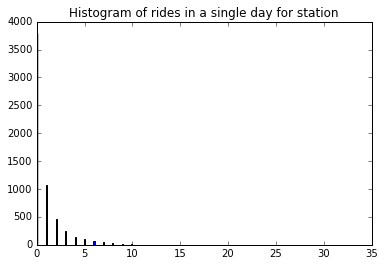

In [65]:
%matplotlib inline
trip_counts = np.array(trip_counts)
total_rides = trip_counts.sum()
print total_rides, len(tripDF)

plt.hist(trip_counts, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram of rides in a single day for station")
plt.savefig('./plots/hist_rides_single_day.png')
plt.show()